In [1]:
# Access astronomical databases
from pyvo import registry  # version >=1.4.1 

# Moc and HEALPix tools
from mocpy import MOC

# Sky visualization
from ipyaladin import Aladin    # version >=0.3.0

# For plots
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pyvo'

# Welcome to VizieR example workflow

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

It is a generic notebook, highlighting what can be done once you chose a catalog. This workflow is suggested by [CDS](https://cdsweb.unistra.fr/) (Strasbourg Astronomical Data Center, house of [VizieR](https://vizier.cds.unistra.fr/viz-bin/VizieR)).

--------------------------------------------------------

Modify the <a href='https://vizier.cds.unistra.fr/'>VizieR catalogue</a> name (variable <b>CATALOGUE</b>) and anything else you might feel like exploring!

## 1. Setup

This example notebook has the following dependencies: 

**Required**
- pyvo : this library facilitates the access to the Virtual Observatory (VO) resources. VizieR is part of the VO.
This notebook needs version >=1.4.1

**Optional, for visualization**
- ipyaladin : this is the Aladin-lite sky viewer, bundled as a jupyter widget. It allows to plot catalogs and multi-order coverages (MOC)
- matplotlib : an other option to see catalog points and MOCs

## 2. Metadata exploration with the Virtual Observatory registry

This part uses [pyvo](https://pyvo.readthedocs.io/en) to connect to the VO registry.

In [2]:
# the catalogue name in VizieR
CATALOGUE = "J/ApJS/79/77"

We first retrieve catalogue information.

In [3]:
# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

In [4]:
# We can print metadata information about the catalogue
voresource.describe(verbose=True)

Bell Lab. H I Survey - High Velocity Clouds
Short Name: J/ApJS/79/77
IVOA Identifier: ivo://cds.vizier/j/apjs/79/77
Access modes: conesearch, tap#aux, web
Multi-capability service -- use get_service()

The sky north of declination -40 deg. was observed in the 21 cm line of atomic
hydrogen with the FWHM = 2 deg. beam of the 20 foot horn reflector at AT&T
Bell Laboratories, Crawford Hill. The survey covers a velocity range of 654
km/s centered on the Galactic standard of rest, with 5.3 km/s wide filters.
This survey is distinguished by its sensitivity to low surface brightness
features (antenna temperature about 50 mK) and relative freedom from sidelobe
contamination. The high-velocity cloud list was extracted and catalogued
automatically from the survey data. Introduction: Observations were made as
drift scans along even declinations between -40 deg. and +90 deg. at the epoch
(1981) of the observations. The horn antenna has a FWHM beam size of 2 deg. at
21 cm. The average rms noise of s

We can also inspect in details the `resource` object and access the attributes not provided by the describe method. See for example, the first author of a resource: 

In [5]:
voresource.creators[0]

'STARK A.A.'

## 3. Access the tabular data of this catalog

We can have a look at the tables available in the catalogue.

In [6]:
tables = voresource.get_tables()
tables

{'J/ApJS/79/77/table2': <VODataServiceTable name="J/ApJS/79/77/table2">... 17 columns ...</VODataServiceTable>}

In [7]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())
tables_names

['J/ApJS/79/77/table2']

The actual data can then be access using any of the ``access_modes`` of the voresource.

In [8]:
voresource.access_modes()

{'conesearch', 'tap#aux', 'web'}

The web access is found by following the ``reference_url``

In [9]:
voresource.reference_url

'https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJS/79/77'

### 3.1 Execute a SQL/ADQL query

The ``tap#aux`` in the ``access_mode`` response indicates that we can also do a SQL/ADQL query for these VizieR tables.

On the first table of the catalogue, we execute an <a href='https://www.ivoa.net/documents/latest/ADQL.html'>ADQL</a> query.

In [10]:
# get the first table of the catalogue
first_table_name = tables_names[0]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(
    f'select TOP 10 * from "{first_table_name}"',
)
tap_records

<DALResultsTable length=10>
recno  num   RA1950  DE1950  pkGLON ...   Flux    antemp  Ncl  _RA_icrs _DE_icrs
              deg     deg     deg   ... K km / s    K            deg      deg   
int32 int16 float64 float64 float64 ... float64  float64 int16 float64  float64 
----- ----- ------- ------- ------- ... -------- ------- ----- -------- --------
 1301  1301   23.72  19.826 102.595 ...     1.65    0.09     1   24.402    20.08
 1231  1231  21.451  19.863  71.498 ...     1.08    0.14     1   22.129   20.121
 1232  1232  21.451  19.863  71.498 ...     4.65    0.14     2   22.129   20.121
 1116  1116   19.35  21.941  56.066 ...   834.58   16.88  1044   20.029   22.203
 1243  1243  21.889  23.851  79.228 ...     1.17    0.13     1   22.577   24.109
 1240  1240  21.681  23.856  76.984 ...     1.23    0.13     1   22.368   24.114
 1300  1300  23.714  25.825 104.893 ...     2.46    0.08     2    24.41   26.079
 1123  1123  19.413  23.937  58.237 ...     1.23    0.11     1   20.096   24.199


<!-- section position -->

We will explore the other access modes here.

### 3.2. Execute a cone search query

We use the Simple Cone Search (<a href='https://www.ivoa.net/documents/latest/ConeSearch.html'>SCS</a>) protocol of the virtual observatory (only available for tables with positions).

Adapt the radius and position of the center to your needs.

In [11]:
conesearch_radius = 1 / 60.0  # in degrees
conesearch_center = (24.389648437500004, 20.085649754206237)

In [12]:
conesearch_records = voresource.get_service("conesearch").search(
    pos=conesearch_center,
    sr=conesearch_radius,
)
conesearch_records

<DALResultsTable length=1>
   _r   recno num   RA1950  DE1950 ...   Flux    antemp  Ncl  _RA.icrs _DE.icrs
                     deg     deg   ... K km / s    K            deg      deg   
float64 int32 str4 float64 float64 ... float32  float32 int16 float64  float64 
------- ----- ---- ------- ------- ... -------- ------- ----- -------- --------
 0.0127  1301 1301  23.720  19.826 ...     1.65    0.09     1  24.4019  20.0802

## 4. Get the catalogue coverage

VizieR also provides the coverage of each catalogue with Multiple Order Coverage (<a href='https://ivoa.net/documents/MOC/'>MOC</a>) at order 10 -- meaning with a 0.001 rad spacial resolution.

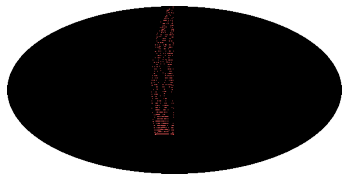

In [13]:
# retrieve the MOC
catalogue_coverage = MOC.from_fits(
    f"https://cdsarc.cds.unistra.fr/viz-bin/moc/{CATALOGUE}",
)
catalogue_coverage.display_preview()

We can plot the coverage with ``matplotlib``.

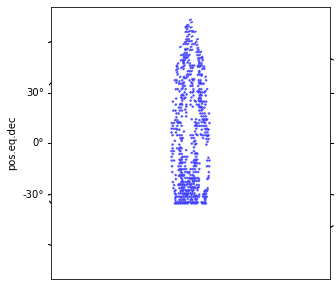

In [14]:
fig = plt.figure(figsize=(5, 5))
wcs = catalogue_coverage.wcs(fig)
ax = fig.add_subplot(projection=wcs)
catalogue_coverage.fill(ax=ax, wcs=wcs, alpha=0.5, color="blue")

or with ipyaladin

In [16]:
aladin = Aladin()
aladin

Aladin(init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opacity', 'gri…

We can add the tables and coverage in this ipyaladin window.

In [17]:
aladin.add_table(conesearch_records.to_table())

In [18]:
aladin.add_table(tap_records.to_table())

In [19]:
aladin.add_moc_from_URL(
    f"https://cdsarc.cds.unistra.fr/viz-bin/moc/{CATALOGUE}",
    moc_options={"opacity": 0.5, "color": "pink"},
)

<ipython-input-19-6fbf199bb952>:1: DeprecationWarning: add_moc_from_URL is replaced by add_moc that detects automaticallythat the MOC was given as an URL.
  aladin.add_moc_from_URL(


For more information about manipulating coverages, see [MOCpy documentation](https://cds-astro.github.io/mocpy/).